## Challenge Set 1  
Topic:        Explore MTA turnstile data (data munging)  
Date:         09/27/2016  
Name:         Nils Hansen  


In [183]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
#import dateutil.parser

from IPython.display import Image

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

1.: Download a couple of MTA data sets and combine them into a data frame

In [184]:
# downloading a couple of MTA data sets and combining them

turnstile_df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160917.txt')
dftemp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160910.txt')
turnstile_df = turnstile_df.append(dftemp, ignore_index = True)
dftemp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160903.txt')
turnstile_df = turnstile_df.append(dftemp, ignore_index = True)
dftemp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160827.txt')
turnstile_df = turnstile_df.append(dftemp, ignore_index = True)
dftemp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160820.txt')
turnstile_df = turnstile_df.append(dftemp, ignore_index = True)


# Sort by C/A, Unit, SCP, Station

turnstile_df = turnstile_df.sort_values(["C/A", "UNIT", "SCP", "STATION"])

In [185]:
turnstile_df.columns = [column.strip() for column in turnstile_df.columns]

2.: Turn this into a time series

In [186]:
# Add a column that combines date and time in the datetime format

#df["DATETIME"] = df["DATE"] + " " + df["TIME"] 
turnstile_df["DATE_TIME"] = pd.to_datetime(turnstile_df.DATE + " " + turnstile_df.TIME, 
                                           format = "%m/%d/%Y %H:%M:%S")

In [187]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstile_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
938152,R634,R069,00-00-00,NEW LOTS AV,2016-08-21 12:00:00,2
938158,R634,R069,00-00-00,NEW LOTS AV,2016-08-22 12:00:00,2
852112,R504,R276,00-00-01,VERNON-JACKSON,2016-09-16 08:00:00,2
938151,R634,R069,00-00-00,NEW LOTS AV,2016-08-21 08:00:00,2
938148,R634,R069,00-00-00,NEW LOTS AV,2016-08-20 20:00:00,2


In [188]:
# Get rid of the duplicate entry
turnstile_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
turnstile_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [189]:
# Get rid of not needed columns

turnstile_df = turnstile_df.drop(['DESC', 'EXITS'], axis = 1, errors = "ignore")

3.: Reduce number of entries to daily data

In [190]:
turnstile_daily = turnstile_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]).ENTRIES.first().reset_index()

In [191]:
turnstile_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,08/13/2016,5781349
1,A002,R051,02-00-00,59 ST,08/14/2016,5782092
2,A002,R051,02-00-00,59 ST,08/15/2016,5783580
3,A002,R051,02-00-00,59 ST,08/16/2016,5785168
4,A002,R051,02-00-00,59 ST,08/17/2016,5786747


In [192]:
# Create new columns with previous date and entries

turnstile_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstile_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .transform(lambda grp: grp.shift(1)))

In [193]:
turnstile_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,08/13/2016,5781349,NaN,NaN
1,A002,R051,02-00-00,59 ST,08/14/2016,5782092,08/13/2016,5.781e+06
2,A002,R051,02-00-00,59 ST,08/15/2016,5783580,08/14/2016,5.782e+06
3,A002,R051,02-00-00,59 ST,08/16/2016,5785168,08/15/2016,5.784e+06
4,A002,R051,02-00-00,59 ST,08/17/2016,5786747,08/16/2016,5.785e+06


In [194]:
# Drop the rows for last date (for these one would need to get another mta file, one week further back)
turnstile_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [195]:
#turnstile_daily[turnstile_daily["ENTRIES"] < turnstile_daily["PREV_ENTRIES"]].head()

In [196]:
# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

turnstile_daily["DAILY_ENTRIES"] = turnstile_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [197]:
turnstile_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,08/14/2016,5782092,08/13/2016,5.781e+06,743.0
2,A002,R051,02-00-00,59 ST,08/15/2016,5783580,08/14/2016,5.782e+06,1488.0
3,A002,R051,02-00-00,59 ST,08/16/2016,5785168,08/15/2016,5.784e+06,1588.0
4,A002,R051,02-00-00,59 ST,08/17/2016,5786747,08/16/2016,5.785e+06,1579.0
5,A002,R051,02-00-00,59 ST,08/18/2016,5788400,08/17/2016,5.787e+06,1653.0


4.: Plot the daily time series for a turnstile.

In [198]:
# Transform the Date column into a date time object

turnstile_daily["DATEADJ"] = pd.to_datetime(turnstile_daily.DATE, format = "%m/%d/%Y")

In [199]:
turnstile_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DATEADJ
1,A002,R051,02-00-00,59 ST,08/14/2016,5782092,08/13/2016,5.781e+06,743.0,2016-08-14
2,A002,R051,02-00-00,59 ST,08/15/2016,5783580,08/14/2016,5.782e+06,1488.0,2016-08-15
3,A002,R051,02-00-00,59 ST,08/16/2016,5785168,08/15/2016,5.784e+06,1588.0,2016-08-16
4,A002,R051,02-00-00,59 ST,08/17/2016,5786747,08/16/2016,5.785e+06,1579.0,2016-08-17
5,A002,R051,02-00-00,59 ST,08/18/2016,5788400,08/17/2016,5.787e+06,1653.0,2016-08-18


In [200]:
plt.figure(figsize=(10,3))

mask = ((turnstile_daily["C/A"] == "A002") & 
        (turnstile_daily["UNIT"] == "R051") & 
        (turnstile_daily["SCP"] == "02-00-00") & 
        (turnstile_daily["STATION"] == "59 ST"))

selected_turnstile = turnstile_daily[(mask)]

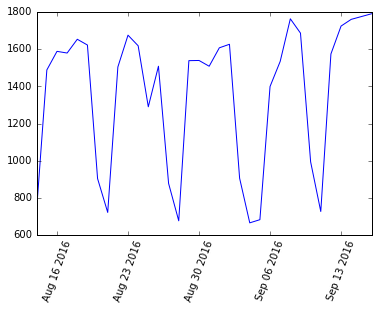

In [201]:
dates = selected_turnstile["DATEADJ"]
counts = selected_turnstile["DAILY_ENTRIES"]

plt.xticks(rotation=70)
plt.plot(dates, counts)

5.: Combine the numbers together for each ControlArea/UNIT/STATION combo

In [202]:
turnstile_combo = (turnstile_daily
                   .groupby(['C/A', 'UNIT', 'STATION','DATEADJ'])
                   .DAILY_ENTRIES
                   .sum()
                   .reset_index()
                   )

In [203]:
turnstile_combo.head()

,C/A,UNIT,STATION,DATEADJ,DAILY_ENTRIES
0,A002,R051,59 ST,2016-08-14,8405.0
1,A002,R051,59 ST,2016-08-15,14988.0
2,A002,R051,59 ST,2016-08-16,16675.0
3,A002,R051,59 ST,2016-08-17,16860.0
4,A002,R051,59 ST,2016-08-18,16859.0


6.: Combine to the station level

In [204]:
turnstile_station = (turnstile_combo
                     .groupby(['STATION','DATEADJ'])
                     .DAILY_ENTRIES
                     .sum()
                     .reset_index()
                     )
    

7.: Plot the time series for a station

In [205]:
mask = ((turnstile_station['STATION'] == "59 ST"))

turnstile_59ST = turnstile_station[mask]

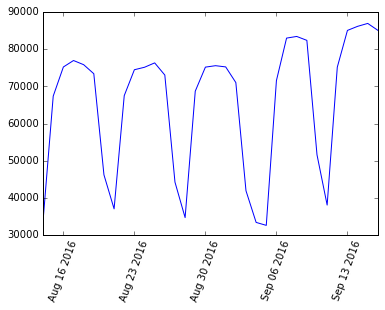

In [206]:
plt.figure()

dates = turnstile_59ST["DATEADJ"]
counts = turnstile_59ST["DAILY_ENTRIES"]

plt.xticks(rotation=70)
plt.plot(dates, counts)


8.: Plot several weeks for one station over one another

In [207]:
# Add weekday names

turnstile_59ST["WEEKDAY"] = turnstile_59ST["DATEADJ"].dt.weekday

/Users/Nils/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [208]:
# Create dataframes for four weeks

ST59_week1 = turnstile_59ST[((turnstile_59ST.DATEADJ >= "2016-08-15") & (turnstile_59ST.DATEADJ <= "2016-08-21"))]
ST59_week2 = turnstile_59ST[((turnstile_59ST.DATEADJ >= "2016-08-22") & (turnstile_59ST.DATEADJ <= "2016-08-28"))]
ST59_week3 = turnstile_59ST[((turnstile_59ST.DATEADJ >= "2016-08-29") & (turnstile_59ST.DATEADJ <= "2016-09-04"))]
ST59_week4 = turnstile_59ST[((turnstile_59ST.DATEADJ >= "2016-09-05") & (turnstile_59ST.DATEADJ <= "2016-09-11"))]

In [209]:
ST59_week1

,STATION,DATEADJ,DAILY_ENTRIES,WEEKDAY
2890,59 ST,2016-08-15,67373.0,0
2891,59 ST,2016-08-16,75197.0,1
2892,59 ST,2016-08-17,76937.0,2
2893,59 ST,2016-08-18,75815.0,3
2894,59 ST,2016-08-19,73388.0,4
2895,59 ST,2016-08-20,46205.0,5
2896,59 ST,2016-08-21,37062.0,6


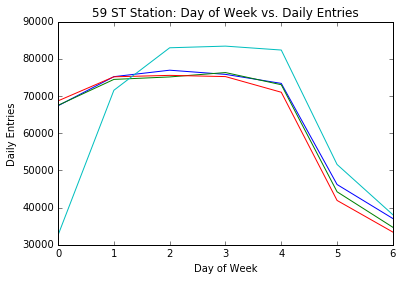

In [210]:
# Plot the weekly data upon each other

plt.plot(ST59_week1["WEEKDAY"], ST59_week1["DAILY_ENTRIES"])
plt.plot(ST59_week2["WEEKDAY"], ST59_week2["DAILY_ENTRIES"])
plt.plot(ST59_week3["WEEKDAY"], ST59_week3["DAILY_ENTRIES"])
plt.plot(ST59_week4["WEEKDAY"], ST59_week4["DAILY_ENTRIES"])

plt.title('59 ST Station: Day of Week vs. Daily Entries')
plt.xlabel('Day of Week')
plt.ylabel('Daily Entries')

9.: Highest total ridership

In [211]:
# Sum up daily entries per station

station_totals=(turnstile_station
                .groupby("STATION")
                .DAILY_ENTRIES.sum()
                .reset_index()
                .sort_values("DAILY_ENTRIES", ascending=False)
                )

10.: Plot Distribution of station totals

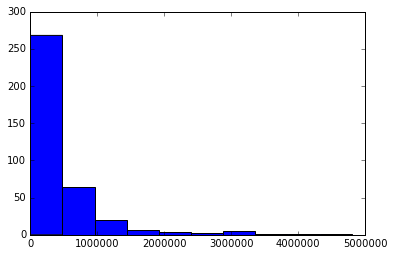

In [212]:
plt.hist(station_totals["DAILY_ENTRIES"]);